<h1 align = "center"><img src=  "http://logok.org/wp-content/uploads/2014/07/Airbnb-new-logo-2014.png" style="width:200px;height:150px;"> Airbnb Data Science Challenge  </h1>

### Requirement

Airbnb is a two sided marketplace which matches guests to hosts. The booking flow at Airbnb  is as follows: a guest finds an available room (listing) that she likes, and she then contacts the  host. There are three ways to send an inquiry a contact, a booking request, or instant book   detailed at the bottom of this document. Upon receiving the inquiry, the host can then decide  whether or not to say yes to the request (accept the request). However, the host may not  accept a guest for many reasons. Some might be logistical, e.g. dates do not work in the  calendar, and some may be more personal, e.g. the guest seems risky.  **Our goal is to help our  guests maximize their likelihood of being accepted by the hosts they contact**.

Suppose we run an experiment where we **require** the guest to write a message that is at least
**140** characters long to explain why he or she is interested in staying with the host, and we run
this as a 50/50 experiment (50% in treatment, 50% in control).

We then look at data on the
contacts and bookings of users in the treatment group compared to the control group. We are
interested in what happens to the experience of contacting and booking a place on Airbnb
when the guest is required to write a message like this. We are also looking for suggestions
for evaluating the future of this change. Should we launch the experiment to everyone or stop
it? How would you explain the results and the decision to someone who was not highly
technical? 

### Summary

Given the goal is to "help our guests maximize their likelihood of being accepted by the hosts they contact", the assumption  for this experiment is that the 140-characters-long message should increase the guests' chance to be accepted. So acceptance rate (the percentage of users accepted by the host after making an inquiry) is used as the  [**one metric that matters**](http://leananalyticsbook.com/one-metric-that-matters/) to determine whether to launch this experiment. If we assume the observed data issues (see *Appendix*) don't affect the record of the acceptance and underlying experiment infrastructure worked fine,  based on the analysis of the difference of acceptance rate between control and treatment groups, my suggestion is that the **experiment should not be launched to everyone at this moment**. There might be an opportunity to lauch it **only in November** based on both multiple comparison and logistic regression results. If there is a strong business reason to launch it to all the traffic, I would recommend to **double check the underlying experiment setting and then launch the experiment to more traffic to increase statistical power.**. 

### Detailed analysis

1. The overall acceptance rate difference between control and treatment is purely due to chance by testing with both parametric and non-parametric methods. After looking at the performance of acceptance rate across different segments, i.e., contact channel, interaction day of the week and interaction month, the difference only becomes statistically significant in November traffic (*without the correction for [multiple comparisons](https://en.wikipedia.org/wiki/Multiple_comparisons_problem)*). The non-zero positive effect of November in acceptance in treatment groupd also gets validated in logistic regression. In generall, the 140-character-long-message does not help increase the chance that the guests get accepted by the hosts but probably in some special season (if we assume November is a holiday season) when hosts might get multiple inquiries at the same time, this message will help the guests stand out among other competitors. However, as there is no demographic information, such as country etc, available in this data, it is hard to validate this theory. Also, as [multiple comparisons](https://en.wikipedia.org/wiki/Multiple_comparisons_problem) are conducted at the same time, the significant result would become insignificant after controling for false discovery rate even for only one metric.   
    
2. Other metrics, i.e., reply rate, booking rate and the latency between interaction and reply are also evaluated here to have a broader picture of the treatment effect on Airbnb site and the treatment did not have a significant impact on any of these metrics in both overall users and different segmentations. Reply rate and the latency between interaction and reply are closely related to the user experience. If a guest could not get a response or have to wait too long for a response, he/she might get frustrated or potentially churn from Airbnb. Booking rate is a revenue indicator for Airbnb.  

3. Various invariant metrics, namely, the metrics that should not be different due to the treatment itself, are similar in control and treatment groups. These metrics include the sample ratio (whether it is 50/50 split), distribution of different contact channels, interaction day of the week and the interaction month.  We want to make sure the randomization was done properly and people in control and treatment are similar in all other dimensions except for the treatment itself so that we can contribute any difference in our metric to the treatment. 

### Further Improvement  & Consideration

1. The segments chosen here are prone to potential "cherry-pick" problem and there might be a more scientific way to choose the corresponding segments to compare the metric for.

2. Probably we can look into another layer of segments within each segment to see whether there is any finding there, such as the interaction month effect for each contact channel. Also, multiple comparison correction should be applied here. 

3. We should also evaluate whether this "requirement" would have advert effect as guests might get pissed off by the length requirement and probably opt out Airbnb.

### Appendix 

|Observed Data Issues| Affected Record Count| Assumption/Reason for Action| Action|
| ------------- |:-------------:| -----|----|
|Users were assigned twice to both control and treatment groups| 393 Users| 1) The initial assignment is based on user rather than inquiry. <br/> 2) It is impossible to decide whether a specific record of these users in the contact table should belong to control or treatment. | Remove|
| Users did not fufill the requirement of writing 140-character-long message in treatment group.    | 664 Users| 1) The message length column for the treatment group refers the message the guests were required to write. <br/> 2) The *require* means that every guest in treatment needs to write that long. <br/> 3) It is only a logging issue (the user did write 140-characters-long but our log went wrong) and does not affect the treatment/control assignment| Keep |
|Users have multiple inquiries | 403 Users |The observations should be independent in the experiment given the assignment is based on users.| Keep the earliest inquiry record |
|Guests's interaction time was later than the hosts' reply time.|144 users| It is either a logging issue or the users' device local time has funny records and it should not affect the occurence of the events such as reply, acceptance and booking| Keep for all the metric calculation except for interaction reply time difference|
|Acceptance of the inquiries made through book it channel did not result in booking event | 9 Users|If the *booking_it_at* recorded the whether booking event ever happened in the inquiry, it might be problematic but if it recorded the final result (the guests or hosts might have canceled) these records were valid.| Keep|
|Users with acceptance record did not have reply record| 2 users| It is potentially a logging issue| Keep and remove only for acceptance rate caculation (given it is only 2 users, it should not affect the test result) | 
|One listing has 2 hosts | 3 Listings| Given Airbnb did not have co-host feature yet, these listings might be suspicious but here i assume it is only a logging issue | Keep| 

<h1 align = "center"> Load the data and the library </h1>

In [1]:
assignment = read.csv("takehome_assignments.csv", header = TRUE, as.is = TRUE)

In [2]:
contact = read.csv("takehome_contacts.csv", header = TRUE, as.is = TRUE)

In [4]:
if(!require(dplyr)){
    install.packages("dplyr")
}
if(!require(lubridate)){
    install.packages("lubridate")
}
if(!require(ggplot2)){
    install.packages("ggplot2")
}
if(!require(tidyr)){
    install.packages("tidyr")
}
if(!require(ggthemes)){
    install.packages("ggthemes")
}
if(!require(scales)){
    install.packages("scales")
}
if(!require(broom)){
    install.packages("broom")
}
if(!require(coefplot)){
    install.packages("coefplot")
}

<h1 align = "center">Data Preprocessing 

### Look at the structure of the raw data

In [5]:
str(assignment)

'data.frame':	10000 obs. of  2 variables:
 $ id_user: chr  "f966752c-8533-48b2-af6f-8c6797d2b247" "873f93fb-234c-4cfb-83c7-27ff0e582a8e" "7308791e-04c3-416a-be2d-4188816decc2" "097c48a4-f4b6-4870-bf29-370e33de868e" ...
 $ ab     : chr  "treatment" "treatment" "control" "control" ...


In [6]:
str(contact)

'data.frame':	10000 obs. of  9 variables:
 $ id_guest              : chr  "f966752c-8533-48b2-af6f-8c6797d2b247" "873f93fb-234c-4cfb-83c7-27ff0e582a8e" "7308791e-04c3-416a-be2d-4188816decc2" "097c48a4-f4b6-4870-bf29-370e33de868e" ...
 $ id_host               : chr  "4405ab66-1c68-449b-abd9-1ad1892a6c4d" "aa41b57b-e29f-4c95-bf27-48f27519e419" "8b118ba1-b439-493e-88c7-2c89a81cec1b" "140b0847-549d-4c77-bb8c-7cea16914871" ...
 $ id_listing            : chr  "fe07e0c4-c317-44bc-a82d-5b599a248049" "d47717da-315a-42c2-8888-9b7d4bea8829" "ac231804-951c-4fcb-a0e6-1a4aecbfb6ce" "727357bd-8031-4e59-b812-22cfa617e031" ...
 $ ts_interaction_first  : chr  "2013-01-01 23:04:35" "2013-01-02 00:21:26" "2013-01-02 02:30:19" "2013-01-02 03:24:06" ...
 $ ts_reply_at_first     : chr  "2013-01-03 23:15:23.0" "2013-01-07 23:38:31.0" "2013-01-02 18:06:10.0" "2013-01-02 17:49:08.0" ...
 $ ts_accepted_at_first  : chr  "NULL" "NULL" "2013-01-02 18:06:10.0" "NULL" ...
 $ ts_booking_at         : chr  "NULL" "NULL"

### Assignment Table

#### Check the duplication of the data

* There are duplications in the ids. The duplications came from two ways:

    1) Pure duplicated records : 513 out of 10,000 rows
    
    2) Different assignment to the same user id: 393 out of 9094 users removed (<font color = "red">This might be worrisome as it implies that underlying experiment implementation might have problems </font>)

##### 513 rows out of 1000 rows removed due to the duplicated assignment

In [7]:
length(unique(assignment$id_user))==nrow(assignment) 

[1] FALSE

In [8]:
sum(duplicated(assignment)) ## 513 duplicated records and we can safely remove it

[1] 513

In [9]:
assignment = assignment %>% unique(.)

In [10]:
length(unique(assignment$id_user))==nrow(assignment) 

[1] FALSE

##### 393 users (about 4.3 %) of the users  removed due to the duplicated assignment

In [11]:
# Count the number of assignments per user 
user_group_assigncount = assignment %>% group_by(id_user) %>% summarise(group_count = n_distinct(ab)) 

In [12]:
table(user_group_assigncount$group_count) #some users have been assigned to both control and treatment group 


   1    2 
8701  393 

In [13]:
nrow(subset(user_group_assigncount, group_count !=1))
length(user_group_assigncount$id_user)
nrow(subset(user_group_assigncount, group_count !=1))/length(user_group_assigncount$id_user)#393 users will be affected 

[1] 393

[1] 9094

[1] 0.04321531

In [14]:
validateAssignment = assignment %>% 
                              inner_join(filter(user_group_assigncount, group_count == 1)) %>% 
                              select(-group_count) %>% 
                              mutate(ab = factor(ifelse(ab == "treatment",1,0))) #change the character to factor

Joining by: "id_user"


In [15]:
length(unique(validateAssignment$id_user))==nrow(validateAssignment) # Double check to make sure one unique user per row

[1] TRUE

In [16]:
summary(validateAssignment)

   id_user          ab      
 Length:8701        0:4349  
 Class :character   1:4352  
 Mode  :character           

### Contact Table

#### Check the duplications of id the contact table

* Some guest ids appear more than once due to multiple inquiry records belonging to the same user. This issue will be taken care of later. 

In [17]:
length(unique(contact$id_guest))==nrow(contact) 

[1] FALSE

In [18]:
sum(duplicated(contact)) #different from the assignment table, the contact table has duplicated id but each record is unique

[1] 0

#### Check missing values: we can see the decreasing numbers through the funnel from reply, to accept, and to booking. 

* Execpt for natural missing in the reply accepted and booking , there is no other missing value

In [19]:
sapply(contact, function(x)sum(is.na(x)|x==""|x == "NULL"))

id_guest                id_host             id_listing 
                     0                      0                      0 
  ts_interaction_first      ts_reply_at_first   ts_accepted_at_first 
                     0                   1429                   6637 
         ts_booking_at    dim_contact_channel m_first_message_length 
                  7829                      0                    117

#### Change the data format & Generate new variables

* Parse the date time values and generate some time related variables including month, date, hour etc for the sanity check later

In [20]:
contact_augmented = contact %>% mutate(
                             ts_interaction_first = ymd_hms(ts_interaction_first),
                             ts_reply_at_first = ymd_hms(ts_reply_at_first),
                             ts_accepted_at_first = ymd_hms(ts_accepted_at_first),
                             ts_booking_at = ymd_hms(ts_booking_at),
                             td_interaction_reply = as.numeric(ts_reply_at_first - ts_interaction_first),
                             td_reply_accepted = as.numeric(ts_accepted_at_first - ts_reply_at_first),
                             td_accepted_booking = as.numeric(ts_booking_at - ts_accepted_at_first),
                             interaction_dayofweek = weekdays(ts_interaction_first), 
                             interaction_year = year(ts_interaction_first),
                             interaction_month = month(ts_interaction_first),
                             interaction_week = as.numeric(format(ts_interaction_first+3, "%U")),
                             interaction_date = date(ts_interaction_first),
                             interaction_hour = hour(ts_interaction_first),
                             interaction_yearmonthweek = as.numeric(paste0(interaction_year, 
                                                                           formatC(interaction_month,
                                                                                   width=2, flag="0"), 
                                                                           formatC(interaction_week, width=2, 
                                                                                   flag="0")))
                             )
                               #NA will be generated for the NULL values in time

Warning message:
:  1429 failed to parse.Warning message:
:  6637 failed to parse.Warning message:
:  7829 failed to parse.

In [21]:
contact_augmented = contact_augmented %>% 
                               mutate( dim_contact_channel = factor(dim_contact_channel),
                                       acceptance = ifelse(is.na(ts_accepted_at_first),0,1), 
                                       reply = ifelse(is.na(ts_reply_at_first),0,1),
                                       booking = ifelse(is.na(ts_booking_at),0,1),
                                       m_first_message_length = ifelse(is.na(m_first_message_length),0,m_first_message_length),
                                       interaction_weekday = ifelse((interaction_dayofweek == "Saturday"| 
                                                                              interaction_dayofweek == "Sunday"),0, 1),
                                       interaction_dayofweek = factor(interaction_dayofweek,
                                         levels=c("Monday", "Tuesday", "Wednesday","Thursday", "Friday", "Saturday", "Sunday"))
                                                 )                                    

### Join the two table together

In [22]:
identical(unique(contact$id_guest), unique(assignment$id_user)) #Check whether the raw tables have the same set of user id 

[1] TRUE

In [23]:
contact_assignment =  inner_join(contact_augmented , validateAssignment, by = c("id_guest" = "id_user"))

<h1 align = "center"> Further Data Cleaning & Sanity Check of the Data Quality 

### Clean the duplicated user_ids in the data

* Given the assumption that the assignment is based on user and the observations in control and treatment groups should be independent, the multiple inquiries made by the same user are unlikely to be independent. So only the earliest inquiry made by each user is used here. 

#### 371 users have more than 1 inquiries in the data

In [24]:
record_count_per_user = contact_assignment %>% 
                                          group_by(id_guest, ab) %>% 
                                          summarise(record_count = n()) %>% 
                                          ungroup() %>% 
                                          mutate(record_count_cat = ifelse(record_count >1, "More_than_1", "1"))  

In [25]:
record_count_user_table = table(record_count_per_user$ab, record_count_per_user$record_count_cat)
record_count_user_table

   
       1 More_than_1
  0 4159         190
  1 4171         181

#### Make sure the more-than-one-inquiry-per-user is not due to the treatment itself

In [26]:
tidy(chisq.test(record_count_user_table))

,statistic,p.value,parameter,method
1,0.185998207113613,0.666268357272036,1,Pearson's Chi-squared test with Yates' continuity correction


#### Only use the earliest inquiry for each user

In [27]:
contact_assignment_one_record = contact_assignment %>% 
                     group_by(id_guest) %>% 
                     arrange(ts_interaction_first) %>% 
                     filter(row_number()==1) %>% ungroup()

In [28]:
nrow(contact_assignment) - nrow(contact_assignment_one_record)

[1] 403

### Check the time skewness in the data 

* The assumptions to test here are:

1) All the *acceptance* events should have *reply* record, all the *booking* events should have *acceptance* record.

2) All the *interaction* should happen earlier than *reply* if any, all the *reply* should happen earlier than *acceptance* if any, all the *acceptance* should happen earlier than *booking* if any.

#### 2 users through contact_me channel had accept record without reply record

In [29]:
any(is.na(subset(contact_assignment_one_record,!is.na(ts_accepted_at_first))$ts_reply_at_first))

[1] TRUE

In [30]:
filter(contact_assignment_one_record, !is.na(ts_accepted_at_first) & is.na(ts_reply_at_first)) %>% 
select(id_guest, ts_reply_at_first, ts_accepted_at_first, dim_contact_channel)

                              id_guest ts_reply_at_first ts_accepted_at_first
1 15b815f1-1538-4f71-a841-d66c590e3939              <NA>  2013-05-27 17:37:53
2 8e403172-761e-44c1-b83c-02617365d8c2              <NA>  2013-11-27 01:08:19
  dim_contact_channel
1          contact_me
2          contact_me

In [31]:
# All the booking records had an acceptance record before
any(is.na(subset(contact_assignment_one_record,!is.na(ts_booking_at)) $ts_accepted_at_first)) 

[1] FALSE

#### 144 users having reply time earlier than the interaction time.
If it is just because of the users' local machine's problem, these observations can stay in the dataset but if it messes up the experiment result, like accepted or booking, these records should be removed. I will keep them for now.

In [32]:
lapply(contact_assignment_one_record[,c("td_interaction_reply", "td_reply_accepted", "td_accepted_booking")], summary)

$td_interaction_reply
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
    -100     1901    13590   170200    58970 50500000     1195 

$td_reply_accepted
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
       0        0        0    67550     1724 57950000     5665 

$td_accepted_booking
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
       0        0        0    41910     2013 11680000     6677 


In [33]:
wrongTimeDiff = contact_assignment_one_record %>% subset(td_interaction_reply <0 & !is.na(td_interaction_reply)) 

In [34]:
length(unique(wrongTimeDiff$id_guest))

[1] 144

### Check the signal of each channel

* The assumptions to test here are:

1) The acceptance of *book_it* channel should lead to a *booking* record unless the *booking* is counted as the final result of the inquiry as the guest might cancel it after being accepted.

2) The interaction from *contact_me* channel should have lead to non-zero length of messages.

3) All the inquries made through *instant_booking* channel should have lead to a *booking* record.

#### 9 users who interacted through"book_it" channel did not result in booking events after getting accepted. 

_It might possible if the guest cancelled the inquiry after the host accepted_

In [35]:
book_it_accepted_nobooking = subset(contact_assignment_one_record, 
                                    dim_contact_channel == "book_it" & 
                                    (!is.na(ts_accepted_at_first)) & is.na(ts_booking_at) )

In [36]:
nrow(book_it_accepted_nobooking)

[1] 9

#### All the "contact_me" channel has resulted in non-zero messages

In [37]:
contact_me_nomessage = subset(contact_assignment_one_record, dim_contact_channel == "contact_me" & is.na(m_first_message_length)  )

In [38]:
nrow(contact_me_nomessage)

[1] 0

#### All the "instant_booking" channel resulted in the booking event

In [39]:
all(!is.na((contact_assignment_one_record %>% filter(dim_contact_channel == "instant_booked")) $ts_booking_at)) 

[1] TRUE

### Check the message length in the treatment group

* The assumptions to test here is:

As the requirement of this challenge mentioned, all the message length in the treatment group should be at least 140-character long if we assume that the message in the treatment group refers to the message they were required to write.

#### 644 users in the test group have message length shorter than 140

In [40]:
test_message_length = subset(contact_assignment_one_record, ab == 1) %>% select(m_first_message_length)

In [41]:
summary(test_message_length)

 m_first_message_length
 Min.   :  51.0        
 1st Qu.: 162.0        
 Median : 269.0        
 Mean   : 323.4        
 3rd Qu.: 416.0        
 Max.   :3182.0        

In [42]:
sum(test_message_length$m_first_message_length<140)

[1] 644

### Check the listing id and host id mapping

* The assumptions to test here is:

One *id_host* can map to several listings but one *id_listing* should have only one host.

#### 3 listing ids were mapped to more than 1 host id 

In [43]:
host_count_per_listing = contact_assignment_one_record %>% group_by(id_listing) %>% summarise(host_count = n_distinct(id_host))

In [44]:
unique(host_count_per_listing$host_count)

[1] 1 2

In [45]:
listingwithDuplicatedHost = host_count_per_listing %>% filter(host_count == 2) %>% select(id_listing) %>% unique(.)

In [46]:
listingwithDuplicatedHost

,id_listing
1,4dfc13e1-fd33-4ca7-8034-7e71a5e5c508
2,58e11b64-982c-451d-a74f-07751fa1ed04
3,90a9f2dc-5f1d-4c60-b86e-ba424385da39


### Summarize the data 

* Given all the inquiries were made in 2013, the acceptance time in 2015 is a little bit suspicious but it might be due to a long-term booking.

In [47]:
summary(contact_assignment_one_record)

   id_guest           id_host           id_listing       
 Length:8701        Length:8701        Length:8701       
 Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character  
                                                         
                                                         
                                                         
                                                         
 ts_interaction_first          ts_reply_at_first            
 Min.   :2013-01-01 06:11:20   Min.   :2013-01-01 18:27:53  
 1st Qu.:2013-04-14 13:18:47   1st Qu.:2013-04-14 15:14:45  
 Median :2013-06-27 20:42:22   Median :2013-07-02 10:57:32  
 Mean   :2013-06-29 05:02:48   Mean   :2013-07-02 04:11:12  
 3rd Qu.:2013-09-10 04:11:42   3rd Qu.:2013-09-14 18:46:37  
 Max.   :2013-12-31 23:24:15   Max.   :2014-10-20 21:20:25  
                               NA's   :1195                 
 ts_accepted_at_first          ts_booking_at    

#### Remove Instant booking as it will always lead to a *booking* event regardless of the treatment

In [48]:
contact_assignment_one_record = subset(contact_assignment_one_record, dim_contact_channel != "instant_booked") %>% 
                     mutate(dim_contact_channel = as.factor(as.character(dim_contact_channel)))

In [49]:
table(contact_assignment_one_record$ab)


   0    1 
4327 4331 

<h1 align = "center"> Data Exploration

### Check the distribution of users across the days in the experiment

* There are more users in the middle of the year compared to the beginning and the end.
* There seems to be more traffic during weekdays than weekends

In [50]:
user_dist = contact_assignment_one_record %>% 
                               group_by(interaction_date, interaction_weekday) %>% 
                               summarise(dailyuser = n())

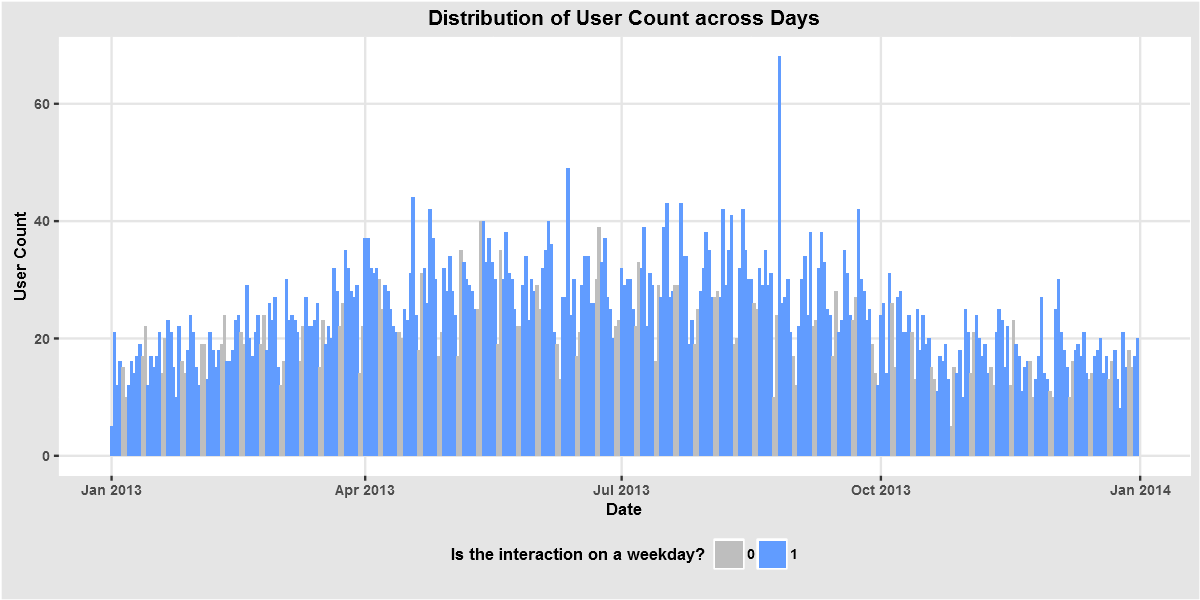

In [51]:
options(jupyter.plot_mimetypes = c("text/plain", "image/png" ), repr.plot.width = 10, repr.plot.height = 5)
ggplot(user_dist, aes(x = interaction_date, y = dailyuser)) + 
    geom_bar(aes(fill = factor(interaction_weekday)), stat = "identity") +
    theme_igray()+
    theme(text  =  element_text(size  =  10, face = "bold"), legend.position = "bottom")  + 
    xlab("Date") + ylab("User Count") + 
    ggtitle("Distribution of User Count across Days") + 
    scale_fill_manual(values = c("1" = "#619CFF","0"= "grey"), name = "Is the interaction on a weekday?") 

### Check the distribution of time difference of reply and interaction 

* Given the distribution is highly skewed, log transformation is applied here. The distributioin of time difference between reply and interaction is similar between control and treatment group across different channels. 

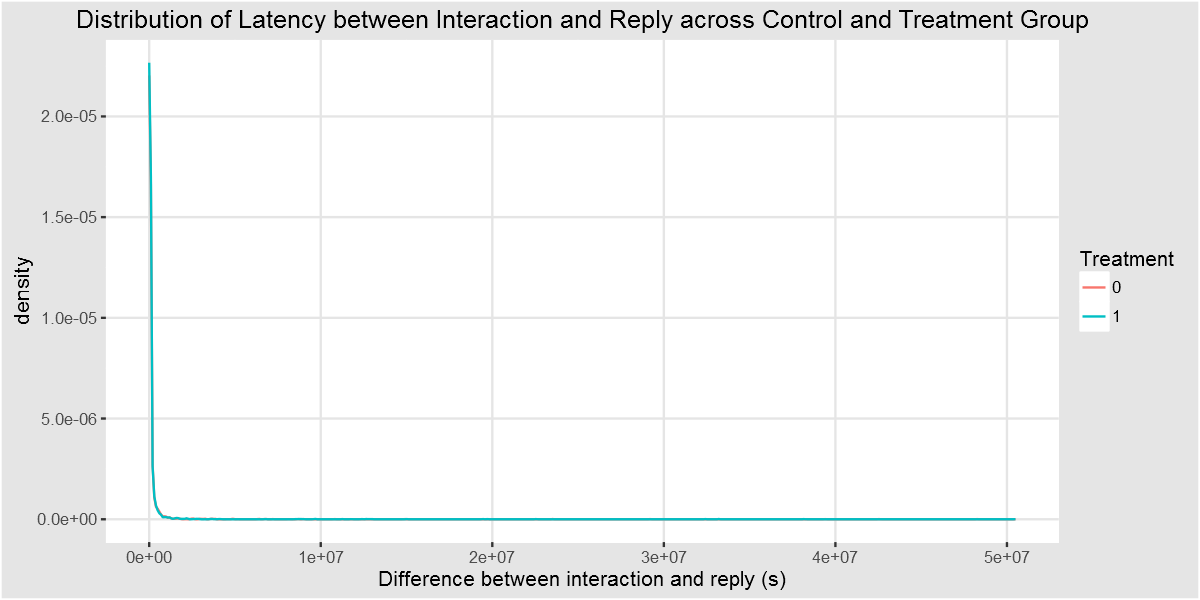

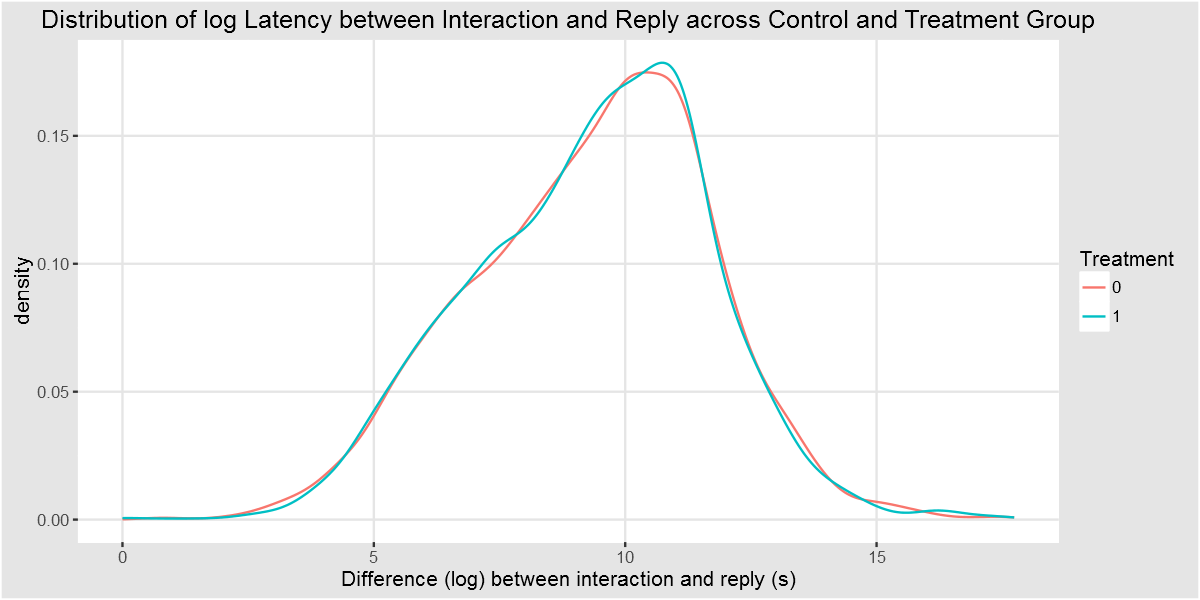

In [52]:
options(jupyter.plot_mimetypes = c("text/plain", "image/png" ), repr.plot.width = 10, repr.plot.height = 5)
ggplot(subset(contact_assignment_one_record, !is.na(td_interaction_reply)&td_interaction_reply>=0), 
       aes(x = td_interaction_reply, group = ab, color =ab)) + 
       geom_line(stat = "density") +
       scale_color_discrete(name = "Treatment") + theme_igray()+
       xlab("Difference between interaction and reply (s)") + 
       ggtitle("Distribution of Latency between Interaction and Reply across Control and Treatment Group") 
ggplot(subset(contact_assignment_one_record, !is.na(td_interaction_reply)&td_interaction_reply>=0), 
       aes(x = log(td_interaction_reply+1), group = ab, color =ab)) +
       geom_line(stat = "density") + theme_igray() +
       scale_color_discrete(name = "Treatment") + xlab("Difference (log) between interaction and reply (s)") + 
       ggtitle("Distribution of log Latency between Interaction and Reply across Control and Treatment Group") 

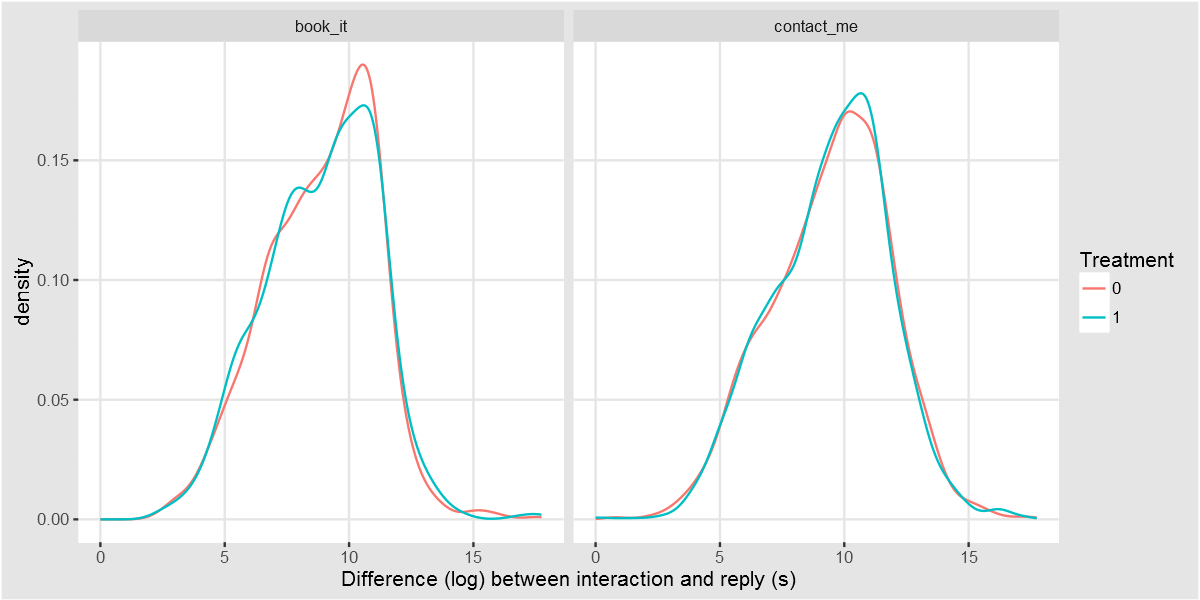

In [53]:
options(jupyter.plot_mimetypes = c("text/plain", "image/png" ), repr.plot.width = 10, repr.plot.height = 5)
ggplot(subset(contact_assignment_one_record, !is.na(td_interaction_reply)&td_interaction_reply>=0), 
       aes(x = log(td_interaction_reply+1), group = ab, color =ab)) + 
       geom_line(stat = "density")+
       facet_grid(.~dim_contact_channel)+ theme_igray()+
       scale_color_discrete(name = "Treatment") + 
       xlab("Difference (log) between interaction and reply (s)")

In [54]:
#Generate the log time difference between interaction and reply
contact_assignment_one_record = contact_assignment_one_record %>% mutate(
                                log_td_interaction_reply = ifelse((!is.na(td_interaction_reply)) & td_interaction_reply >=0, 
                                    log(td_interaction_reply + 1), NA)) 

Warning message:
In log(c(165, NA, 180202, 35938, 1191, 353, 1712, 1358, NA, 49855, : NaNs produced

<h1 align = "center"> Sanity Check (Invariant Metric)

Invariant metrics are the metrics that should not change between control and treatment group.

### Control/Treatment Sample Ratio Check

* Overall, the control and treatment ratio is very close to 1

In [55]:
ab_assignment_table = table(contact_assignment_one_record$ab)
ab_assignment_table


   0    1 
4327 4331 

In [56]:
tidy(prop.test(ab_assignment_table,0.5))%>% 
       select(-parameter,-statistic, -method,-alternative)

,estimate,p.value,conf.low,conf.high
1,0.4997690,0.9742796,0.4891818,0.5103565


### Invariant Segmentation Check

#### Contact channel distribution

* The distribution of contact channel within either control or treatment group looks similar

In [57]:
ab_channel_dist = contact_assignment_one_record %>% 
                                     group_by(ab, dim_contact_channel) %>% 
                                     summarise(user_count = n()) 

In [58]:
ab_channel_dist

,ab,dim_contact_channel,user_count
1,0,book_it,864
2,0,contact_me,3463
3,1,book_it,876
4,1,contact_me,3455


In [59]:
ab_channel_dist_spread = ab_channel_dist %>% spread( key = dim_contact_channel, value = user_count)
ab_channel_dist_spread

,ab,book_it,contact_me
1,0,864,3463
2,1,876,3455


In [60]:
tidy(chisq.test(ab_channel_dist_spread[,-1]))

,statistic,p.value,parameter,method
1,0.0747752159546226,0.784506881775937,1,Pearson's Chi-squared test with Yates' continuity correction


#### The day of week distribution

 * If different users in different days of week behaves differently, e.g., people are more likely to write a sincere note on weekends compared to weekdays or the host has more patience to read a long note on weekends compared to weekdays, the unbalanced distribution might bias the experiment result.

* The distribution of the day of the week within either control or treatment looks similar with fewer users on weekend.


_**Note:**:The first and last day of 2013 are both Tuesdays but given it is only a day, it should not affect the general picture_

In [61]:
ab_dayofweek_dist = contact_assignment_one_record %>% group_by(ab, interaction_dayofweek) %>% summarise(user_count = n())

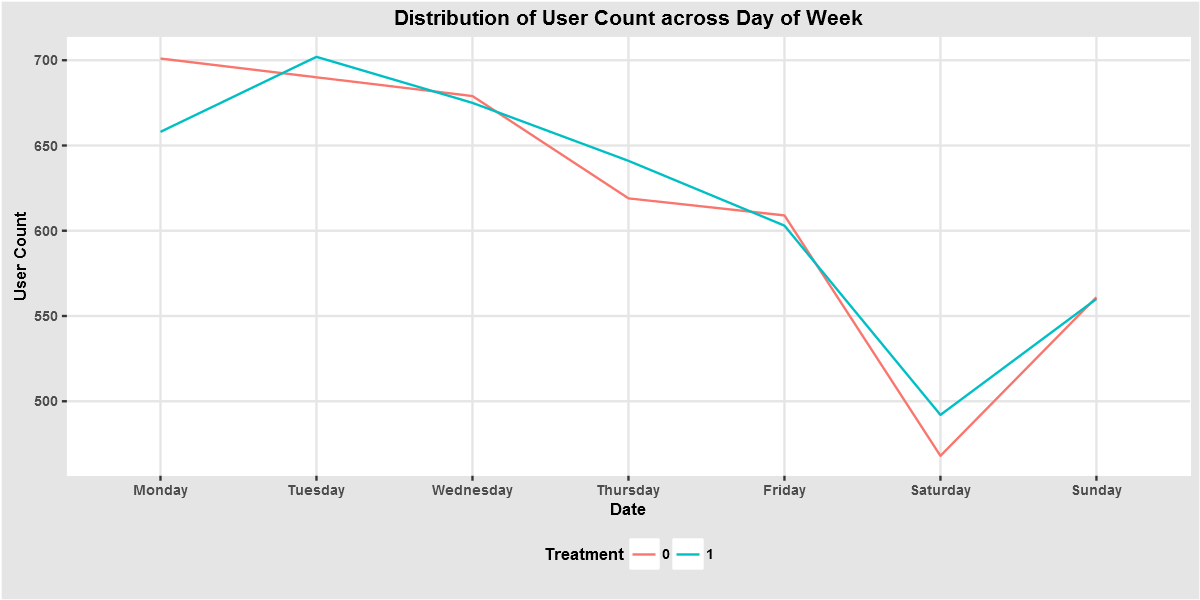

In [62]:
options(jupyter.plot_mimetypes = c("text/plain", "image/png" ), repr.plot.width = 10, repr.plot.height = 5)

ggplot(ab_dayofweek_dist, aes(x = factor(interaction_dayofweek), y = user_count, group = factor(ab))) + 
   geom_line(aes(color = factor(ab))) +
   theme_igray()+
   theme(text  =  element_text(size  =  10, face = "bold"), legend.position = "bottom")  + 
   xlab("Date") + ylab("User Count") + 
   ggtitle("Distribution of User Count across Day of Week") +scale_color_discrete(name = "Treatment")

#### Sanity Check the month distribution

* Given Airbnb is a traveling company, seasonality is important. For example, the inquries in the popular months might be more likely to get rejected given too many inquries the host get.
* The monthly user distritbution between treatment and control group has similar trend with more inquries in the middle of the year.

In [63]:
ab_month_dist = contact_assignment_one_record %>% group_by(ab, interaction_month) %>% summarise(user_count = n())

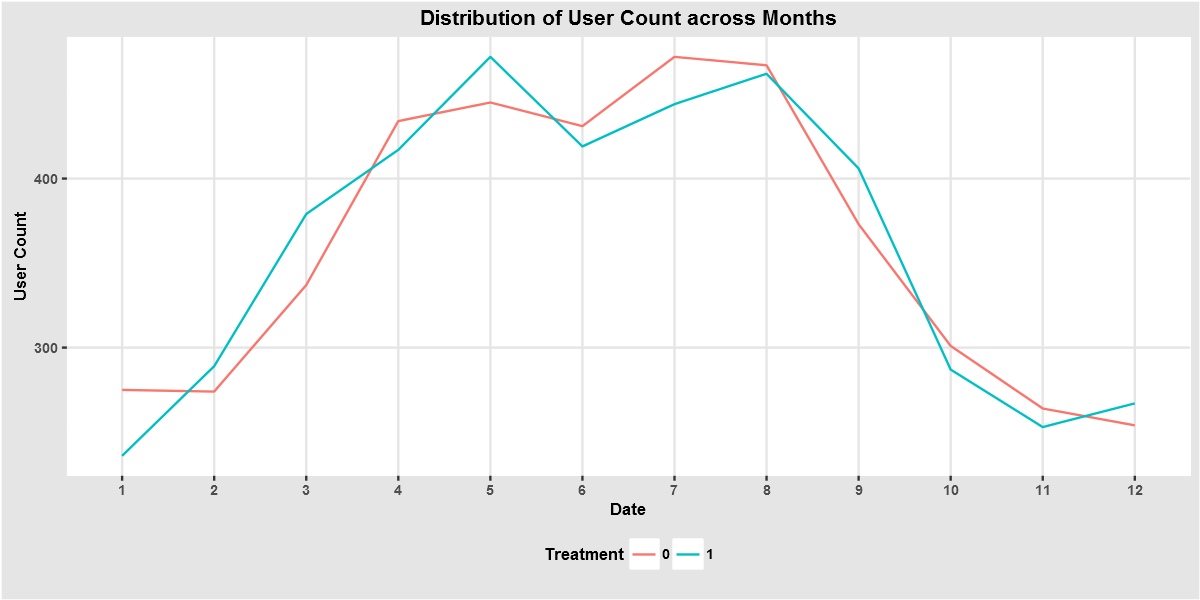

In [64]:
options(jupyter.plot_mimetypes = c("text/plain", "image/png" ), repr.plot.width = 10, repr.plot.height = 5)

ggplot(ab_month_dist, aes(x = factor(interaction_month), y = user_count, group = factor(ab))) + geom_line(aes(color = factor(ab))) +
                             theme_igray()+
                 theme(text  =  element_text(size  =  10, face = "bold"), legend.position = "bottom")  + 
                 xlab("Date") + ylab("User Count") + 
                 ggtitle("Distribution of User Count across Months") + scale_color_discrete(name = "Treatment")

#### Sanity check the user count in treatment and control across the month and different contact channels

In [65]:
channelcount_month_ab = contact_assignment_one_record %>% 
                            group_by(interaction_month,ab, dim_contact_channel) %>% 
                            summarise(count = n()) %>% ungroup() %>% 
            unite(ab_dim_contact_channel, ab, dim_contact_channel, remove = FALSE)

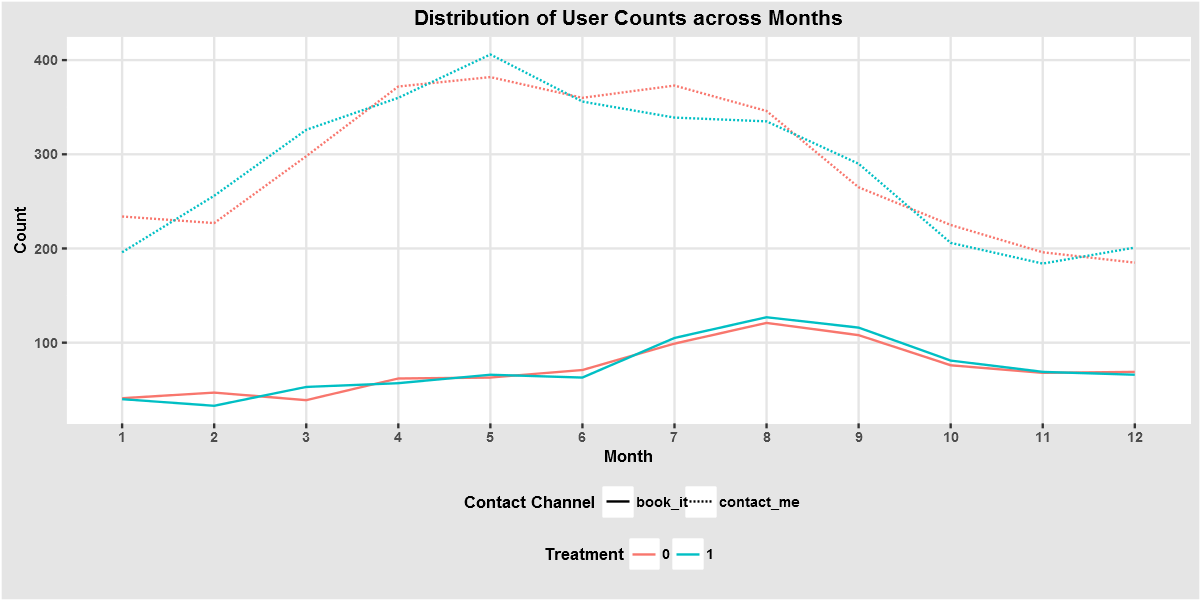

In [66]:
options(jupyter.plot_mimetypes = c("text/plain", "image/png" ), repr.plot.width = 10, repr.plot.height = 5)
ggplot(channelcount_month_ab, aes(x = factor(interaction_month), 
                                 y = count,
                                 color = ab, 
                                 group = ab_dim_contact_channel, linetype = dim_contact_channel)) + 
                             geom_line() +
                             theme_igray()+
                 theme(text  =  element_text(size  =  10, face = "bold"), legend.position = "bottom")  + 
                 xlab("Month") + ylab("Count") + 
                 ggtitle("Distribution of User Counts across Months") + 
                 scale_color_discrete(name = "Treatment") + scale_linetype_discrete(name = "Contact Channel")

#### Sanity check the user count in treatment and control across different day of week and different contact channels

In [67]:
channelcount_dayofweek_ab = contact_assignment_one_record %>% 
                            group_by(interaction_dayofweek,ab,dim_contact_channel) %>% 
                            summarise(count = n()) %>% ungroup() %>% 
            unite(ab_dim_contact_channel, ab, dim_contact_channel, remove = FALSE)

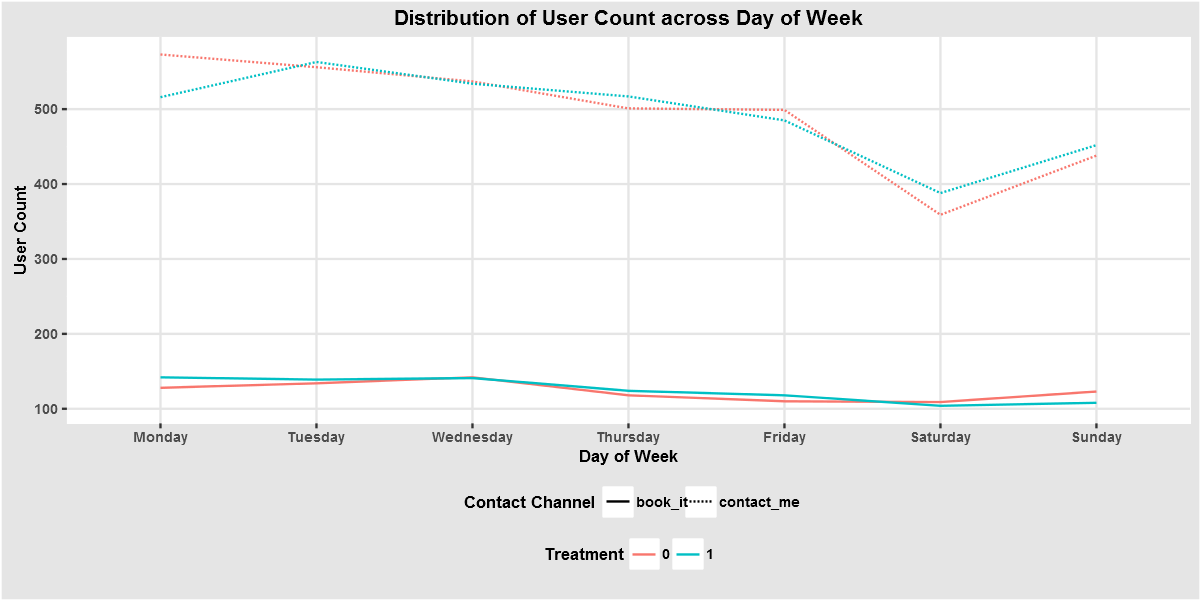

In [68]:
options(jupyter.plot_mimetypes = c("text/plain", "image/png" ), repr.plot.width = 10, repr.plot.height = 5)
ggplot(channelcount_dayofweek_ab, aes(x = factor(interaction_dayofweek), 
                                 y = count,
                                 color = ab, linetype = as.factor(dim_contact_channel),
                                 group = ab_dim_contact_channel)) + 
                             geom_line() +
                             theme_igray()+
                 theme(text  =  element_text(size  =  10, face = "bold"), legend.position = "bottom")  + 
                 xlab("Day of Week") + ylab("User Count") + 
                 ggtitle("Distribution of User Count across Day of Week") + 
                 scale_color_discrete(name = "Treatment") + 
                 scale_linetype_discrete(name = "Contact Channel")

<h1 align = "center">Analyze the A/B testing result

Accetance rate (the percentage of the inquries accepted by the host) is used as [**one metric that matters**](http://leananalyticsbook.com/one-metric-that-matters/)  to decide whether to launch this experiment or not. We should also view other metrics such as the reply rate, booking rate, and time difference between interaction and reply to have a sense about how this treatment affects other metrics.

### Overall metrics

#### Parametric Method

##### Acceptance Rate

In [69]:
contact_assignment_one_record%>% group_by(ab) %>% summarise(total = n(),
    acceptanceRate = sum(!is.na(ts_accepted_at_first))/n())

,ab,total,acceptanceRate
1,0,4327,0.348278252831061
2,1,4331,0.343569614407758


In [70]:
tidy(t.test(contact_assignment_one_record$acceptance[contact_assignment_one_record$ab == 0], 
       contact_assignment_one_record$acceptance[contact_assignment_one_record$ab == 1])) %>% 
       select(-parameter,-statistic, -method,-alternative)

,estimate,estimate1,estimate2,p.value,conf.low,conf.high
1,0.004708638,0.348278253,0.343569614,0.645172856,-0.015335144,0.024752421


##### Reply Rate

In [71]:
tidy(t.test(contact_assignment_one_record$reply[contact_assignment_one_record$ab == 0], 
       contact_assignment_one_record$reply[contact_assignment_one_record$ab == 1])) %>% 
       select(-parameter,-statistic, -method,-alternative)

,estimate,estimate1,estimate2,p.value,conf.low,conf.high
1,-0.006826541,0.858562514,0.865389056,0.357227034,-0.021360578,0.007707496


##### Booking rate

In [72]:
tidy(t.test(contact_assignment_one_record$booking[contact_assignment_one_record$ab == 0], 
       contact_assignment_one_record$booking[contact_assignment_one_record$ab == 1])) %>% 
       select(-parameter,-statistic, -method,-alternative)

,estimate,estimate1,estimate2,p.value,conf.low,conf.high
1,-0.0009435847,0.2283337185,0.2292773032,0.9167791174,-0.0186444713,0.0167573020


##### Latency between interaction and reply

In [73]:
tidy(t.test(contact_assignment_one_record$log_td_interaction_reply[contact_assignment_one_record$ab == 0], 
       contact_assignment_one_record$log_td_interaction_reply[contact_assignment_one_record$ab == 1]))  %>% 
       select(-parameter,-statistic, -method,-alternative)

,estimate,estimate1,estimate2,p.value,conf.low,conf.high
1,0.00284059,9.32861767,9.32577708,0.95895628,-0.10535636,0.11103754


### Check the cumulative metrics across the days

* As [this blog](http://nerds.airbnb.com/experiments-at-airbnb/) pointed out, the experiment data at Airbnb has the convergence tendency over the day.
* We can see that the difference of acceptance rate, booking rate and reply rate between control and treatment group becomes stable after 3 months and the latency between interaction and reply converges to 0 after October. All the effect sizes are very close to 0 and p value is never less than 0.05.  

In [74]:
uniqueDates = sort(unique(contact_assignment_one_record$interaction_date))#get all the dates
cumulativeTable =data.frame(date = uniqueDates, replyRateDiff = rep(NA, 365), 
                            acceptanceRateDiff = rep(NA, 365),
                            bookingRateDiff = rep(NA, 365),
                            meanofLogTimeDiff = rep(NA, 365)) #construct an empty table

In [75]:
cumulativePvalueTable =data.frame(date = uniqueDates, replyRateDiff_pvalue = rep(NA, 365), 
                            acceptanceRateDiff_pvalue = rep(NA, 365),
                            bookingRateDiff_pvalue = rep(NA, 365),
                            meanofLogTimeDiff_pvalue = rep(NA, 365))

In [76]:
for (i in 1:365){
    data = subset(contact_assignment_one_record, interaction_date <=cumulativeTable$date[i])
    cumulativeTable[i, "replyRateDiff"] = mean(data[data$ab==1,]$reply) - mean(data[data$ab==0,]$reply)
    cumulativeTable[i, "acceptanceRateDiff"] = mean(data[data$ab==1,]$acceptance) -mean(data[data$ab==0, ]$acceptance) 
    cumulativeTable[i, "bookingRateDiff"] = mean(data[data$ab == 1,]$booking) - mean (data[data$ab==0, ]$booking)
    cumulativeTable[i, "meanofLogTimeDiff"] = mean(data[data$ab == 1,]$log_td_interaction_reply, na.rm =TRUE) -
    mean (data[data$ab==0, ]$log_td_interaction_reply, na.rm = TRUE)
}

In [77]:
for (i in 2:365){
    data = subset(contact_assignment_one_record, interaction_date <=cumulativeTable$date[i])
    control = subset(data, ab == 0)
    treatment = subset(data, ab == 1)
    cumulativePvalueTable[i, "replyRateDiff_pvalue"] = t.test(control$reply, treatment$reply)$p.value
    cumulativePvalueTable[i, "acceptanceRateDiff_pvalue"] = t.test(control$acceptance, treatment$acceptance)$p.value 
    cumulativePvalueTable[i, "bookingRateDiff_pvalue"] = t.test(control$booking ,treatment$booking)$p.value
    cumulativePvalueTable[i, "meanofLogTimeDiff_pvalue"] = t.test(control$log_td_interaction_reply, 
                                                                  treatment$log_td_interaction_reply)$p.value
} #the first day is omitted here due to the consistency effect in t-test

##### Acceptance Rate

Warning message:
: Removed 1 rows containing missing values (geom_path).

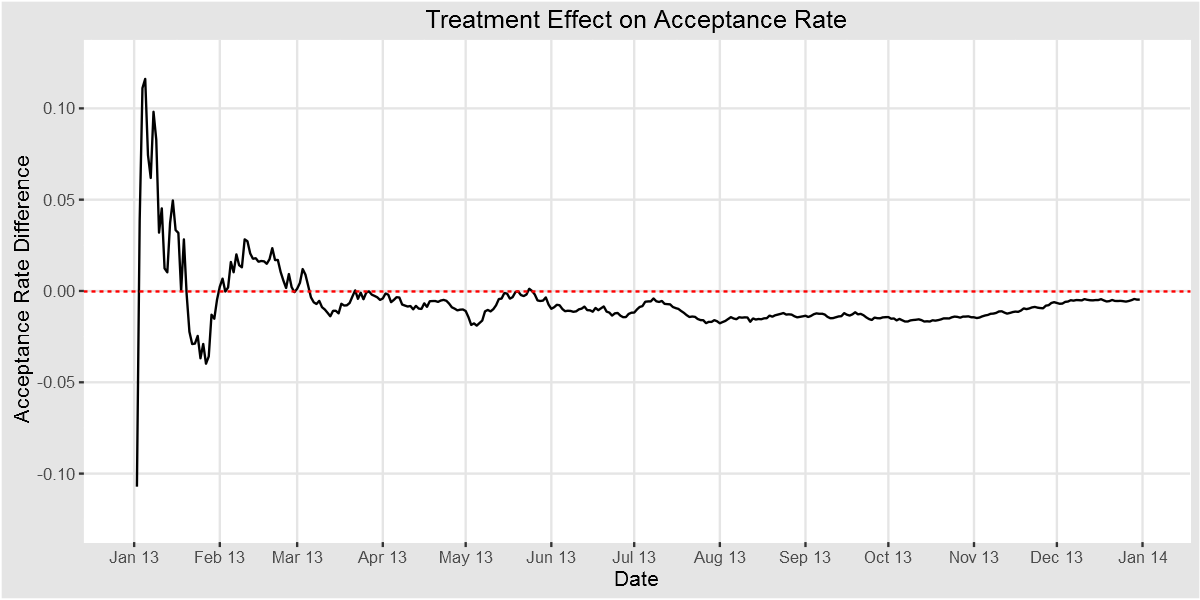

In [78]:
options(jupyter.plot_mimetypes = c("text/plain", "image/png" ), repr.plot.width = 10, repr.plot.height = 5)
ggplot(cumulativeTable, aes(x = date, y=acceptanceRateDiff)) + 
       geom_line() + 
       geom_hline(yintercept = 0, color = "red", linetype = 2) + 
       scale_x_date(date_breaks = "1 month",date_labels = "%b %y") + 
       xlab ("Date") + 
       ylab("Acceptance Rate Difference") + theme_igray()+
       ggtitle("Treatment Effect on Acceptance Rate") + ylim(-0.125, 0.125)

Warning message:
: Removed 1 rows containing missing values (geom_path).

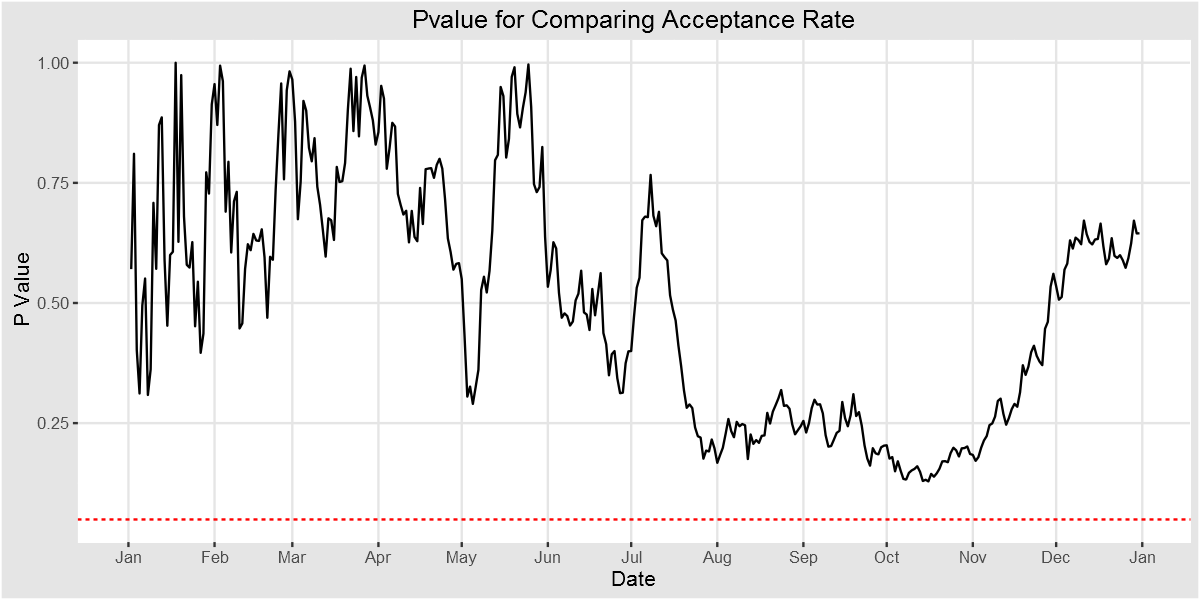

In [79]:
options(jupyter.plot_mimetypes = c("text/plain", "image/png" ), repr.plot.width = 10, repr.plot.height = 5)
ggplot(cumulativePvalueTable, aes(x = date, y=acceptanceRateDiff_pvalue)) + 
geom_line()+ 
geom_hline(yintercept = 0.05, color = "red", linetype = 2) + 
       scale_x_date(date_breaks = "1 month",date_labels = "%b")+  
       xlab ("Date") +theme_igray()+
       ylab("P Value") + ggtitle("Pvalue for Comparing Acceptance Rate") 

##### Reply Rate

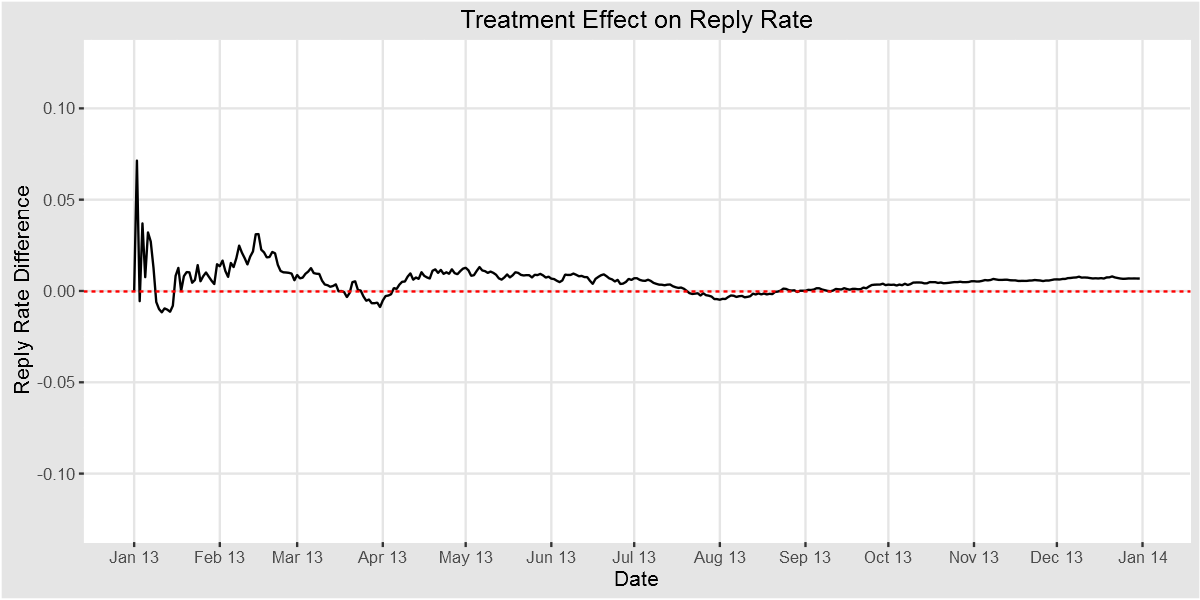

In [80]:
options(jupyter.plot_mimetypes = c("text/plain", "image/png" ), repr.plot.width = 10, repr.plot.height = 5)
ggplot(cumulativeTable, aes(x = date, y = replyRateDiff)) + 
       geom_line() + 
       geom_hline(yintercept = 0, color = "red", linetype = 2) + 
       scale_x_date(date_breaks = "1 month",date_labels = "%b %y") + 
       xlab ("Date") +
       ylab("Reply Rate Difference") + theme_igray()+
       ggtitle("Treatment Effect on Reply Rate") + ylim(c(-0.125, 0.125))

Warning message:
: Removed 1 rows containing missing values (geom_path).

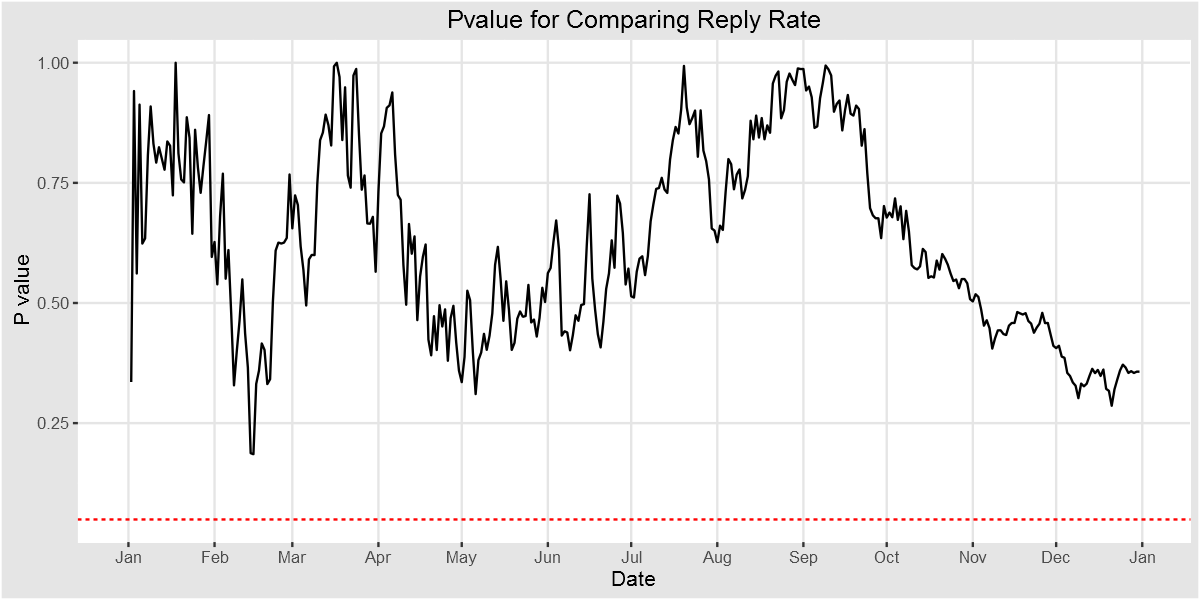

In [81]:
options(jupyter.plot_mimetypes = c("text/plain", "image/png" ), repr.plot.width = 10, repr.plot.height = 5)
ggplot(cumulativePvalueTable, aes(x = date, y=replyRateDiff_pvalue)) + 
geom_line()+ 
geom_hline(yintercept = 0.05, color = "red", linetype = 2) + 
       scale_x_date(date_breaks = "1 month",date_labels = "%b")+  
       xlab ("Date") +theme_igray()+
       ylab("P value") + ggtitle("Pvalue for Comparing Reply Rate") 

##### Booking rate

Warning message:
: Removed 1 rows containing missing values (geom_path).

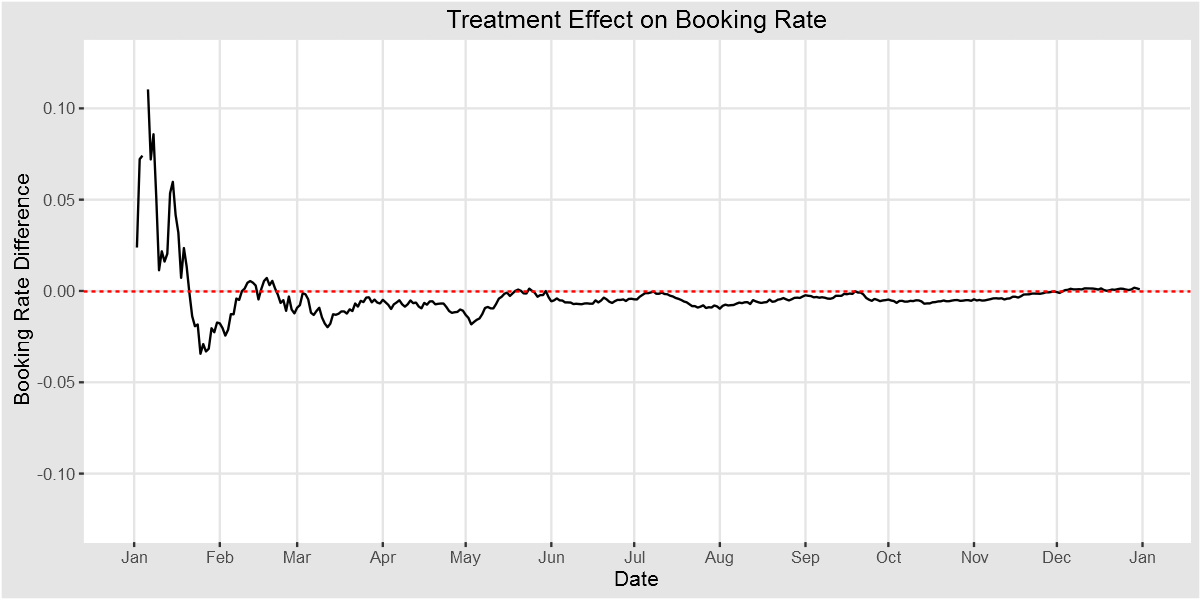

In [82]:
options(jupyter.plot_mimetypes = c("text/plain", "image/png" ), repr.plot.width = 10, repr.plot.height = 5)
ggplot(cumulativeTable, aes(x = date, y=bookingRateDiff)) + 
geom_line()+ 
geom_hline(yintercept = 0, color = "red", linetype = 2) + 
       scale_x_date(date_breaks = "1 month",date_labels = "%b")+  
       xlab ("Date") + theme_igray()+
       ylab("Booking Rate Difference") + ggtitle("Treatment Effect on Booking Rate") + ylim(-0.125, 0.125)

Warning message:
: Removed 1 rows containing missing values (geom_path).

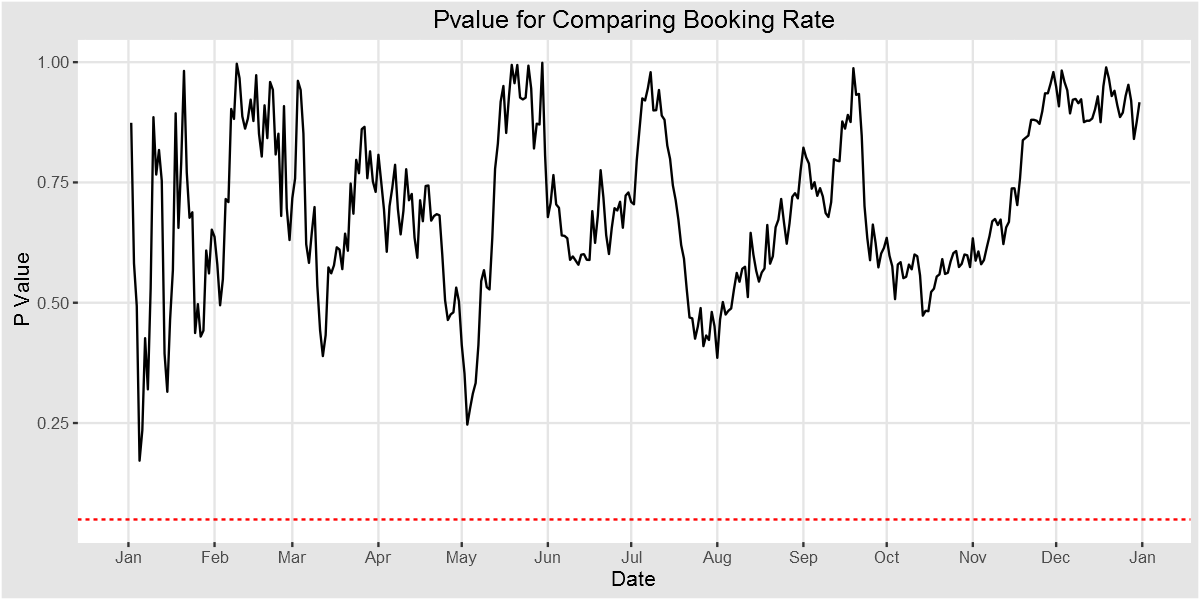

In [83]:
options(jupyter.plot_mimetypes = c("text/plain", "image/png" ), repr.plot.width = 10, repr.plot.height = 5)
ggplot(cumulativePvalueTable, aes(x = date, y= bookingRateDiff_pvalue)) + 
geom_line()+ 
geom_hline(yintercept = 0.05, color = "red", linetype = 2) + 
       scale_x_date(date_breaks = "1 month",date_labels = "%b")+  
       xlab ("Date") + theme_igray()+
       ylab("P Value") + ggtitle("Pvalue for Comparing Booking Rate") 

##### Latency between interaction and reply

Warning message:
: Removed 1 rows containing missing values (geom_path).

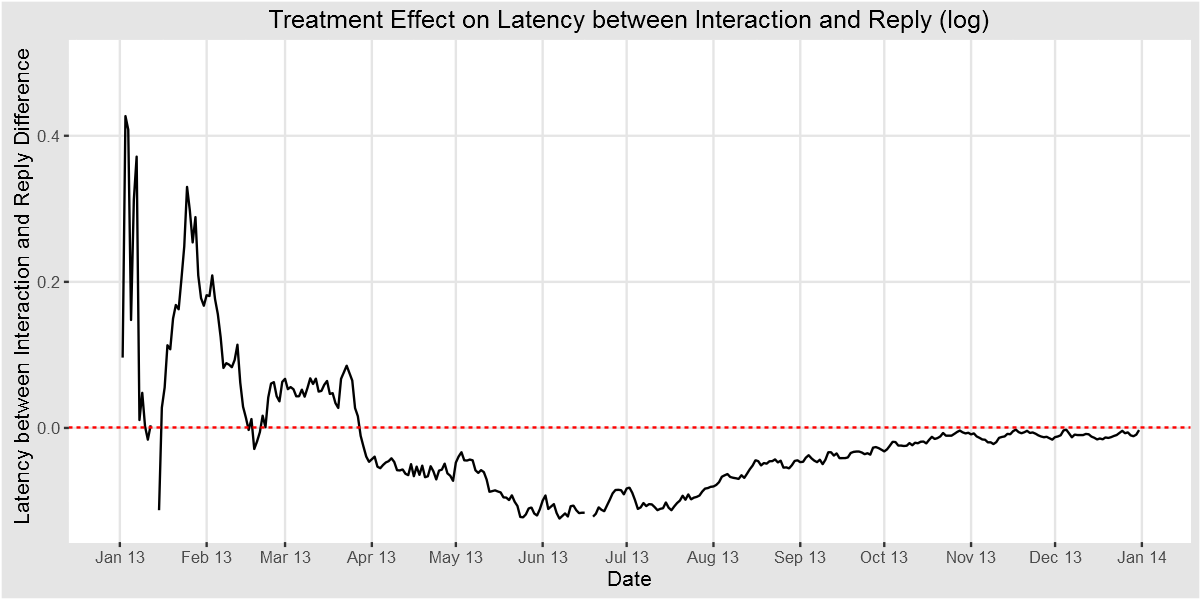

In [84]:
options(jupyter.plot_mimetypes = c("text/plain", "image/png" ), repr.plot.width = 10, repr.plot.height = 5)
ggplot(cumulativeTable, aes(x = date, y = meanofLogTimeDiff)) + 
       geom_line() + 
       geom_hline(yintercept = 0, color = "red", linetype = 2) + 
       scale_x_date(date_breaks = "1 month",date_labels = "%b %y") + 
       xlab ("Date") + theme_igray()+
       ylab("Latency between Interaction and Reply Difference") + 
       ggtitle("Treatment Effect on Latency between Interaction and Reply (log)") + ylim(-0.125, 0.5)

Warning message:
: Removed 1 rows containing missing values (geom_path).

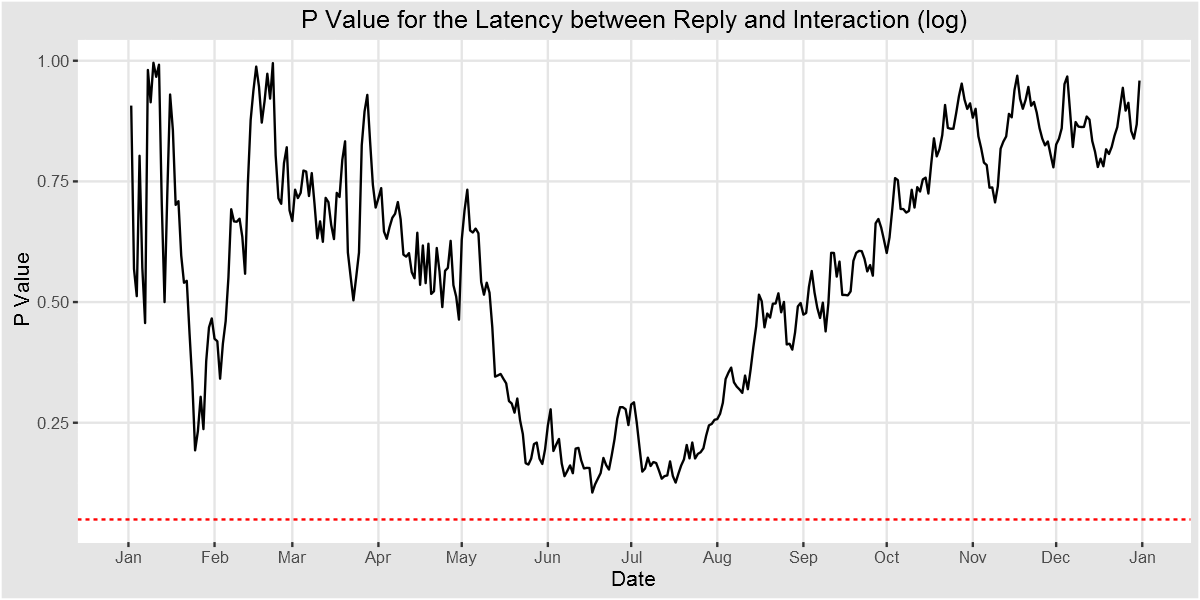

In [85]:
options(jupyter.plot_mimetypes = c("text/plain", "image/png" ), repr.plot.width = 10, repr.plot.height = 5)
ggplot(cumulativePvalueTable, aes(x = date, y= meanofLogTimeDiff_pvalue)) + 
geom_line()+ 
geom_hline(yintercept = 0.05, color = "red", linetype = 2) + 
       scale_x_date(date_breaks = "1 month",date_labels = "%b")+  
       xlab ("Date") + theme_igray()+
       ylab("P Value") + ggtitle("P Value for the Latency between Reply and Interaction (log)") 

#### Non-parametric Method

##### Acceptance Rate

In [86]:
tidy(wilcox.test(acceptance ~ ab, data = contact_assignment_one_record))

,statistic,p.value,method,alternative
1,9414239,0.645149503528417,Wilcoxon rank sum test with continuity correction,two.sided


##### Reply Rate

In [87]:
tidy(wilcox.test(reply ~ ab, data = contact_assignment_one_record))

,statistic,p.value,method,alternative
1,9306153,0.357196278758942,Wilcoxon rank sum test with continuity correction,two.sided


##### Booking Rate

In [88]:
tidy(wilcox.test(booking ~ ab, data = contact_assignment_one_record))

,statistic,p.value,method,alternative
1,9361277,0.916776704128829,Wilcoxon rank sum test with continuity correction,two.sided


##### Time Difference between interaction and reply

In [89]:
tidy(wilcox.test(td_reply_accepted ~ ab, data = contact_assignment_one_record))

,statistic,p.value,method,alternative
1,1091635.5,0.157251777579359,Wilcoxon rank sum test with continuity correction,two.sided


### Metric by Different Contact Channel

* Construct the functions to avoid the verbose in coding

In [90]:
generateTestingResult = function(data, metric){  
    test = t.test(unlist(data[data$ab==1, metric]), unlist(data[data$ab==0,metric]) )
    p_value = test$p.value
    control = test$estimate[2]
    treatment = test$estimate[1] 
    difference = treatment - control
    result = data.frame(p_value, control, treatment, difference)
    return(result)                
} #get the result for each individual test

In [91]:
getTestingResult_Group = function(df,segment, metric){
    result = df %>% group_by_(segment) %>% do( generateTestingResult (data = ., metric = metric) )
    return(result)
} # get the result for each segment

##### Acceptance Rate

In [92]:
getTestingResult_Group(df = contact_assignment_one_record, segment = "dim_contact_channel", metric = "acceptance")

,dim_contact_channel,p_value,control,treatment,difference
1,book_it,0.248716578431133,0.583333333333333,0.555936073059361,-0.0273972602739726
2,contact_me,0.993288303330958,0.289633265954375,0.28972503617945,9.17702250752273e-05


##### Reply Rate

In [93]:
getTestingResult_Group(df = contact_assignment_one_record, segment = "dim_contact_channel", metric = "reply")

,dim_contact_channel,p_value,control,treatment,difference
1,book_it,0.349012611248342,0.920138888888889,0.907534246575342,-0.0126046423135464
2,contact_me,0.181597407907714,0.843199537972856,0.854703328509407,0.0115037905365508


##### Booking Rate

In [94]:
getTestingResult_Group(df = contact_assignment_one_record, segment = "dim_contact_channel", metric = "booking")

,dim_contact_channel,p_value,control,treatment,difference
1,book_it,0.231232989936592,0.578703703703704,0.550228310502283,-0.0284753932014206
2,contact_me,0.408763941495093,0.140918278948888,0.147901591895803,0.00698331294691493


##### Time Difference between interaction and reply

In [95]:
getTestingResult_Group(df = subset(contact_assignment_one_record, td_interaction_reply>=0 & !is.na( ts_reply_at_first)), 
                       segment = "dim_contact_channel", metric = "log_td_interaction_reply")

,dim_contact_channel,p_value,control,treatment,difference
1,book_it,0.908433078713908,8.90076182492048,8.88763379603484,-0.0131280288856388
2,contact_me,0.999773901057307,9.44204303433267,9.44202529510684,-1.77392258287057e-05


### Segment the ab testing result by day of the week

##### Acceptance Rate

In [96]:
getTestingResult_Group(df = contact_assignment_one_record, segment = "interaction_dayofweek", metric = "acceptance")

,interaction_dayofweek,p_value,control,treatment,difference
1,Monday,0.393078603507989,0.359486447931526,0.337386018237082,-0.0221004296944443
2,Tuesday,0.514009943910092,0.350724637681159,0.367521367521368,0.0167967298402081
3,Wednesday,0.54745202663834,0.360824742268041,0.345185185185185,-0.015639557082856
4,Thursday,0.416894828339987,0.324717285945073,0.346333853354134,0.0216165674090615
5,Friday,0.14380448630285,0.35303776683087,0.313432835820896,-0.0396049310099748
6,Saturday,0.516183335335484,0.33974358974359,0.359756097560976,0.0200125078173858
7,Sunday,0.721240266112548,0.344028520499109,0.333928571428571,-0.0100999490705374


##### Reply Rate

In [97]:
getTestingResult_Group(df = contact_assignment_one_record, segment = "interaction_dayofweek", metric = "reply")

,interaction_dayofweek,p_value,control,treatment,difference
1,Monday,0.949951953128549,0.865905848787446,0.864741641337386,-0.00116420745006041
2,Tuesday,0.654671493503951,0.879710144927536,0.871794871794872,-0.00791527313266438
3,Wednesday,0.146315247384761,0.848306332842415,0.875555555555556,0.0272492227131402
4,Thursday,0.0230560770309904,0.836833602584814,0.881435257410296,0.0446016548254822
5,Friday,0.388146356709377,0.858784893267652,0.875621890547264,0.0168369972796119
6,Saturday,0.154831978250669,0.856837606837607,0.823170731707317,-0.0336668751302898
7,Sunday,0.723837227495403,0.86096256684492,0.853571428571429,-0.00739113827349125


##### Booking Rate

In [98]:
getTestingResult_Group(df = contact_assignment_one_record, segment = "interaction_dayofweek", metric = "booking")

,interaction_dayofweek,p_value,control,treatment,difference
1,Monday,0.421737921461217,0.249643366619116,0.231003039513678,-0.0186403271054377
2,Tuesday,0.395861385231952,0.217391304347826,0.236467236467236,0.0190759321194104
3,Wednesday,0.653026379587337,0.24300441826215,0.232592592592593,-0.0104118256695576
4,Thursday,0.246161702144126,0.208400646203554,0.235569422776911,0.027168776573357
5,Friday,0.450418539352176,0.220032840722496,0.202321724709784,-0.0177111160127115
6,Saturday,0.562856419425522,0.22008547008547,0.235772357723577,0.0156868876381072
7,Sunday,0.845126689314462,0.235294117647059,0.230357142857143,-0.00493697478991598


##### Latency between interaction and reply

In [99]:
getTestingResult_Group(df = subset(contact_assignment_one_record, td_interaction_reply>=0 & !is.na( ts_reply_at_first)), 
                       segment = "interaction_dayofweek", metric = "log_td_interaction_reply")

,interaction_dayofweek,p_value,control,treatment,difference
1,Monday,0.262849191724905,9.33068056007727,9.16987533764619,-0.160805222431081
2,Tuesday,0.635712158359081,9.13087473313663,9.19210849784912,0.061233764712485
3,Wednesday,0.806360240277373,9.26971639353591,9.23454403568067,-0.0351723578552416
4,Thursday,0.482270429939656,9.24839104068358,9.35210481895555,0.10371377827197
5,Friday,0.67607358196601,9.38279803743861,9.44567920146433,0.0628811640257201
6,Saturday,0.525498994088193,9.46737467219844,9.36487145602501,-0.102503216173433
7,Sunday,0.79433958328764,9.55667015775717,9.59579549305427,0.0391253352971006


### Segment the ab testing result by the month

##### Acceptance Rate

In [100]:
getTestingResult_Group(df = contact_assignment_one_record, segment = "interaction_month", metric = "acceptance")

,interaction_month,p_value,control,treatment,difference
1,1.000000000,0.913295298,0.381818182,0.377118644,-0.004699538
2,2.000000000,0.869195222,0.339416058,0.346020761,0.006604703
3,3.000000000,0.790649235,0.347181009,0.337730871,-0.009450138
4,4.00000000,0.46165197,0.31336406,0.29016787,-0.02319619
5,5.000000000,0.951636558,0.301123596,0.302966102,0.001842506
6,6.0000000,0.3203809,0.3201856,0.2887828,-0.0314028
7,7.00000000,0.22208557,0.35805085,0.31981982,-0.03823103
8,8.000000000,0.957889648,0.353319058,0.354978355,0.001659297
9,9.00000000,0.54680236,0.37801609,0.35714286,-0.02087323
10,10.00000000,0.77475182,0.40531561,0.39372822,-0.01158739


In [101]:
p.adjust(getTestingResult_Group(df = contact_assignment_one_record, segment = "interaction_month", metric = "acceptance")$p_value, 
         method = "fdr") #become insiginificant after controlling for fdr

[1] 0.9578896 0.9578896 0.9578896 0.9578896 0.9578896 0.9578896 0.9578896
 [8] 0.9578896 0.9578896 0.9578896 0.0760378 0.9578896

##### Reply Rate

In [102]:
getTestingResult_Group(df = contact_assignment_one_record， segment = "interaction_month", metric = "reply")  

,interaction_month,p_value,control,treatment,difference
1,1.00000000,0.59586400,0.88363636,0.89830508,0.01466872
2,2.0000000000,0.9917884234,0.8722627737,0.8719723183,-0.0002904554
3,3.00000000,0.19518429,0.89910979,0.86807388,-0.03103591
4,4.00000000,0.03535693,0.80184332,0.85611511,0.05427179
5,5.000000000,0.878046838,0.842696629,0.838983051,-0.003713578
6,6.000000000,0.916062024,0.819025522,0.816229117,-0.002796405
7,7.00000000,0.02099503,0.87288136,0.81756757,-0.05531379
8,8.00000000,0.25011247,0.84368308,0.87012987,0.02644679
9,9.00000000,0.27425676,0.86595174,0.89162562,0.02567387
10,10.00000000,0.23801134,0.86378738,0.89547038,0.03168301


##### Booking Rate

In [103]:
getTestingResult_Group(df = contact_assignment_one_record, segment = "interaction_month", metric = "booking")     

,interaction_month,p_value,control,treatment,difference
1,1.00000000,0.65201692,0.25454545,0.23728814,-0.01725732
2,2.000000000,0.909708015,0.208029197,0.204152249,-0.003876948
3,3.000000e+00,9.980426e-01,2.373887e-01,2.374670e-01,7.829443e-05
4,4.00000000,0.44425952,0.20046083,0.17985612,-0.02060471
5,5.00000000,0.48384870,0.19325843,0.21186441,0.01860598
6,6.000000000,0.742976259,0.192575406,0.183770883,-0.008804523
7,7.00000000,0.31641066,0.23940678,0.21171171,-0.02769507
8,8.00000000,0.31386199,0.23126338,0.25974026,0.02847688
9,9.00000000,0.44982049,0.25737265,0.23399015,-0.02338251
10,10.000000000,0.835326572,0.272425249,0.264808362,-0.007616887


##### Time Difference between interaction and reply

In [104]:
getTestingResult_Group(df = subset(contact_assignment_one_record, td_interaction_reply>=0 & !is.na( ts_reply_at_first)), 
                       segment = "interaction_month", metric = "log_td_interaction_reply")

,interaction_month,p_value,control,treatment,difference
1,1.0000000,0.4662303,9.2273750,9.3946986,0.1673236
2,2.00000000,0.80070772,9.61123516,9.55597490,-0.05526026
3,3.0000000,0.2171959,9.6506871,9.4322821,-0.2184051
4,4.0000000,0.4559029,9.7968130,9.6639678,-0.1328452
5,5.0000000,0.1911442,9.7320120,9.5050600,-0.2269520
6,6.000000000,0.966761356,9.451298930,9.443394445,-0.007904485
7,7.0000000,0.7719511,9.4232190,9.3744307,-0.0487883
8,8.0000000,0.2772108,9.0217955,9.2016334,0.1798379
9,9.0000000,0.5309039,9.1023936,9.2172727,0.1148790
10,10.0000000,0.2296153,8.8283275,9.0812857,0.2529582


<h1 align = "center"> Logistic regression 

* Here I use logistic regression to test the correlation between the segment and the acceptance likelihood.
* We can see that only the coefficients of November between control and treatment are different in the signs and they are both statistically significant, which is consistent with our multiple testing result.

In [105]:
lg_model_overall = glm(factor(acceptance)~  
                        factor(interaction_month) + factor (interaction_dayofweek)+ factor(dim_contact_channel)+  factor(ab),
                        data = contact_assignment_one_record,family = binomial("logit"))

In [106]:
lg_model0 = glm(factor(acceptance) ~  
               factor(interaction_month) + factor (interaction_dayofweek)
               + factor(dim_contact_channel),
               data = subset(contact_assignment_one_record, ab == 0),family = binomial("logit"))

In [107]:
lg_model1 = glm(factor(acceptance) ~  
               factor(interaction_month) + factor (interaction_dayofweek)
               + factor(dim_contact_channel),
               data = subset(contact_assignment_one_record, ab == 1),family = binomial("logit"))

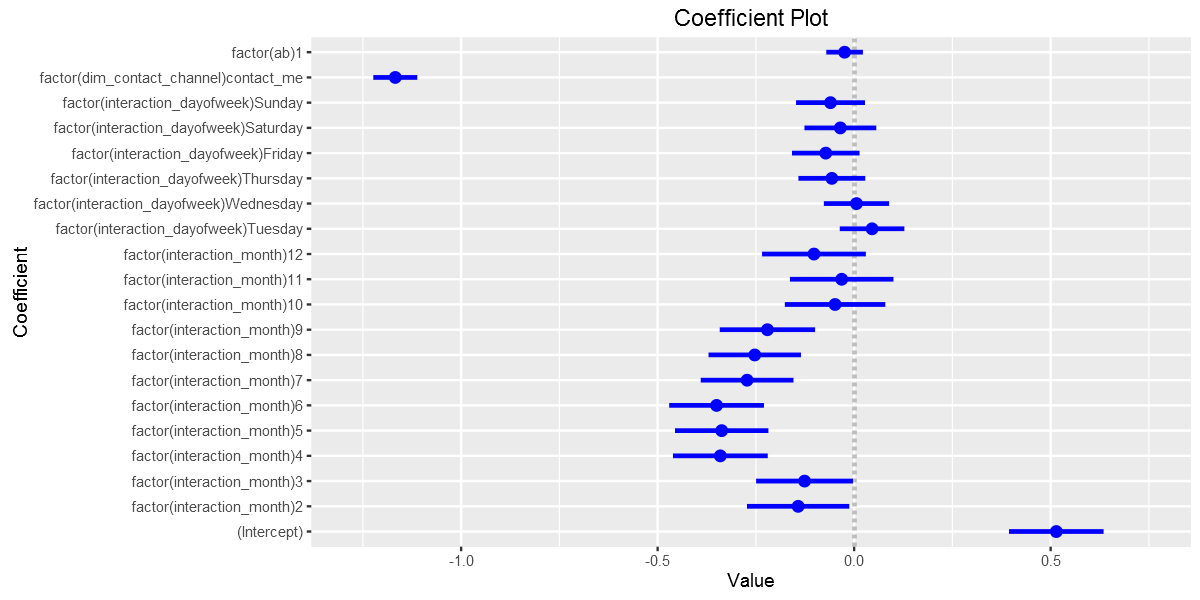

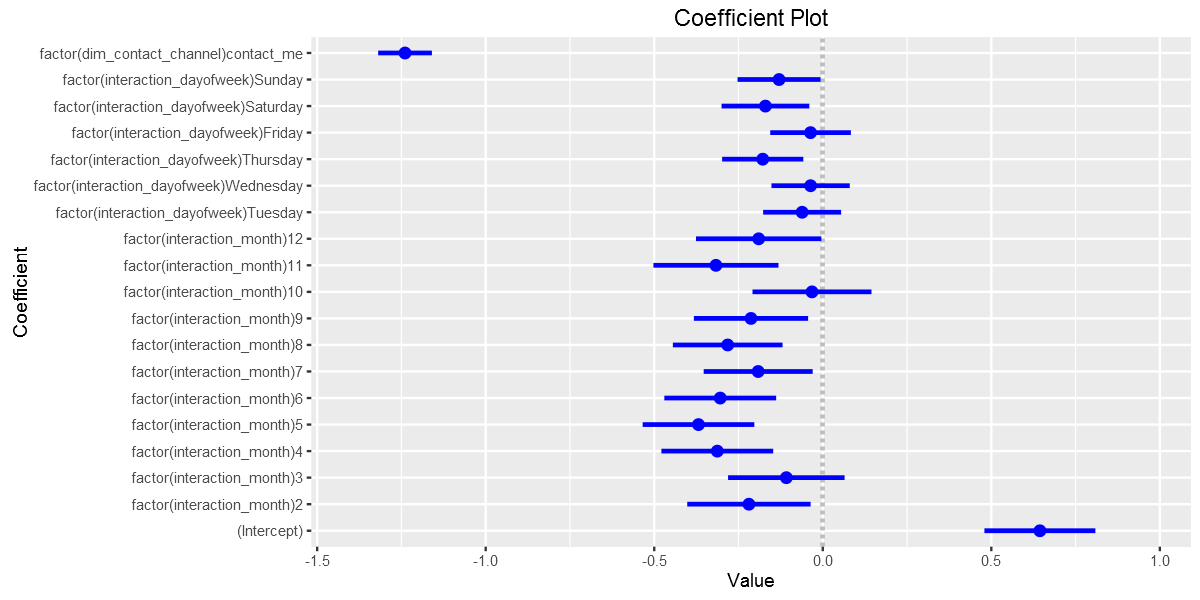

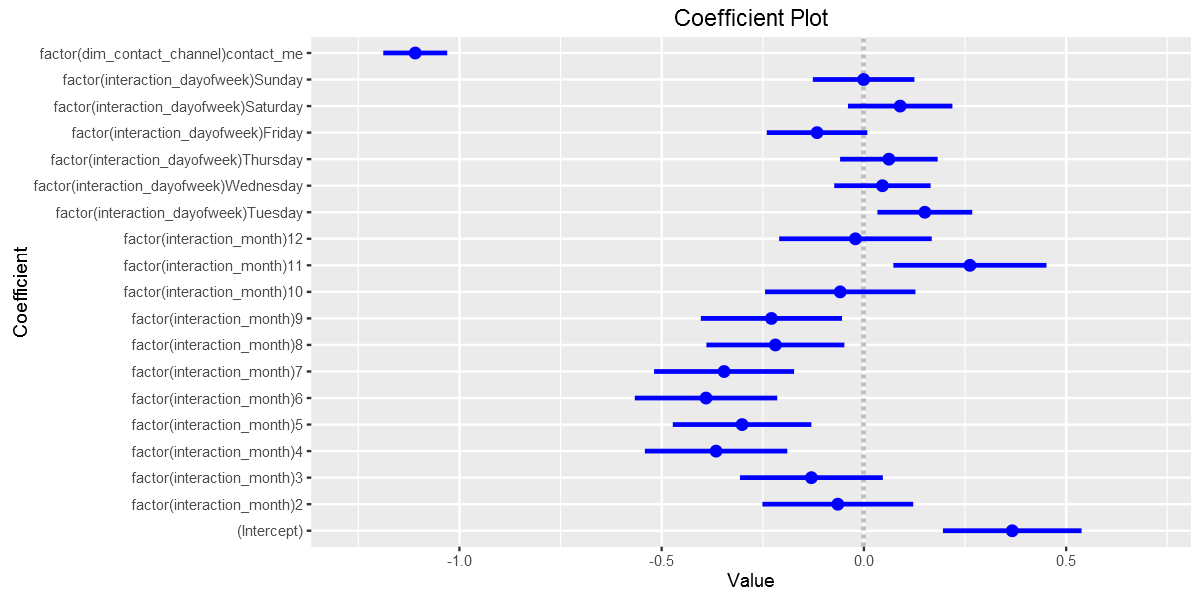

In [108]:
par(mfrow = c(nr = 1, nc = 3)) #the ir kernel did not work well with the par option
coefplot(lg_model_overall)
coefplot(lg_model0)
coefplot(lg_model1)